In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

In [3]:

class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter:
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = ProgressMeter._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print2(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    @classmethod
    def _get_batch_fmtstr(cls, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self.nclass = num_classes

    def forward(self, x):
        conv_features = self.features(x)
        flatten = conv_features.view(conv_features.size(0), -1)
        fc = self.fc_layers(flatten)
        return fc


def get_datasets(*args, **kwargs):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

    trainset = torchvision.datasets.CIFAR10(train=True, transform=transform, *args, **kwargs)
    testset = torchvision.datasets.CIFAR10(train=False, transform=transform, *args, **kwargs)
    return trainset, testset


def get_dataloaders(trainset, testset, batch_size=100, num_worker=4):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_worker)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_worker)

    return trainloader, testloader


def get_model(model_src_path, device='cpu'):
    model = Net(num_classes=10)
    state_dict = torch.load(model_src_path, map_location=device)
    model.load_state_dict(state_dict)
    return model


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        if type(output) is tuple:
            _, _, output = output
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res, pred[0, :]


def eval_single_batch_compute(x, y, model):
    output = model(x)
    accs, predictions = accuracy(output, y, topk=(1,))
    acc = accs[0]
    return acc, predictions


def eval_model(model, dataloader, print_acc=False, device='cpu', log_update_feq=20):
    model.eval()
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(
        len(dataloader),
        [top1],
        prefix='Evaluating Batch'
    )

    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            x, y = data

            x = x.to(device)
            y = y.to(device)
            n_data = y.size(0)

            acc, predictions = eval_single_batch_compute(x, y, model)

            top1.update(acc.item(), n_data)
            if idx % log_update_feq == log_update_feq - 1:
                progress.print2(idx + 1)

        if print_acc:
            print(' * Acc@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

In [35]:
import torch.nn.utils.prune as prune
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainset, testset = get_datasets(root='./data', download=True)
_, testloader = get_dataloaders(trainset, testset, batch_size=100, num_worker=16)


Files already downloaded and verified
Files already downloaded and verified


In [36]:
for j in [0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]:
#for i in range(1):
    model_src_path = 'model.tar' # todo you need to set the path to downloaded model !!
    model = get_model(model_src_path, device)
    module = model.features
    for i in range(len(module)):
        if i in [0,3,6,8,10]:
            prune.l1_unstructured(module[i], name="weight", amount=j)
    module = model.fc_layers
    for i in range(len(module)):
        if i in [1,4,6]:
            prune.l1_unstructured(module[i], name="weight", amount=j)
    eval_model(model, testloader, print_acc=True, device=device)

Evaluating Batch[ 20/100]	Acc@1  86.00 ( 86.30)
Evaluating Batch[ 40/100]	Acc@1  87.00 ( 86.33)
Evaluating Batch[ 60/100]	Acc@1  87.00 ( 86.05)
Evaluating Batch[ 80/100]	Acc@1  89.00 ( 86.14)
Evaluating Batch[100/100]	Acc@1  86.00 ( 86.24)
 * Acc@1 86.240
Evaluating Batch[ 20/100]	Acc@1  86.00 ( 86.30)
Evaluating Batch[ 40/100]	Acc@1  87.00 ( 86.33)
Evaluating Batch[ 60/100]	Acc@1  87.00 ( 86.03)
Evaluating Batch[ 80/100]	Acc@1  88.00 ( 86.10)
Evaluating Batch[100/100]	Acc@1  86.00 ( 86.20)
 * Acc@1 86.200
Evaluating Batch[ 20/100]	Acc@1  86.00 ( 86.20)
Evaluating Batch[ 40/100]	Acc@1  87.00 ( 86.25)
Evaluating Batch[ 60/100]	Acc@1  87.00 ( 85.98)
Evaluating Batch[ 80/100]	Acc@1  88.00 ( 86.03)
Evaluating Batch[100/100]	Acc@1  86.00 ( 86.13)
 * Acc@1 86.130
Evaluating Batch[ 20/100]	Acc@1  86.00 ( 85.80)
Evaluating Batch[ 40/100]	Acc@1  86.00 ( 86.03)
Evaluating Batch[ 60/100]	Acc@1  87.00 ( 85.88)
Evaluating Batch[ 80/100]	Acc@1  88.00 ( 85.95)
Evaluating Batch[100/100]	Acc@1  84.00 (

In [46]:
prune = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
acc = [11.12,13.17,32.05,56.92,75.96,81.77,85.3,85.72,86.08,86.13,86.2,86.24]
acc = acc[::-1]

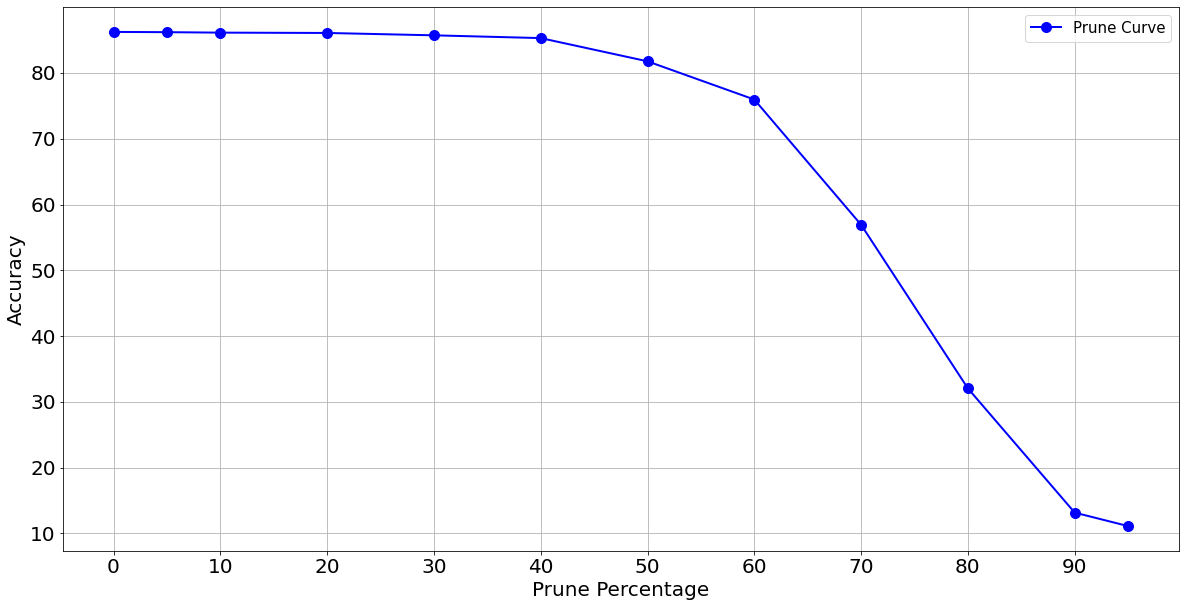

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# activations
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
line1, = ax.plot(prune,acc,label='Prune Curve',linewidth=2,color='b',marker='o',markersize=10)
#line2, = ax.plot(vgg_idx,vgg_inputs,label='VGG16',linewidth=2,color='r',marker='s',markersize=10)
plt.legend(handles=[line1],loc=0,fontsize=15)
ax.grid()
ax.set_xlabel('Prune Percentage',fontsize=20)
ax.set_ylabel('Accuracy',fontsize=20)
ax.tick_params(axis='both',labelsize=20)
ax.set_xticks(np.arange(0,100,10))
plt.show()

0.2